# Multi-reference alignment


This notebook gathers the code for the multi-reference part of the paper "Alleviating Label Switching with Optimal Transport".

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import ot 

First, we define our target signal. Then, we generate samples, shifting the signal by random steps and adding noise.

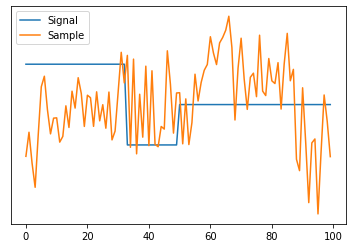

In [34]:
#define and plot signal
N=100
x = np.zeros(N)
x[:N//3]=10
x[N//2:]=5

cur_axes = plt.gca()
time= np.linspace(0,2*np.pi,N)
plt.plot(np.roll(x + np.random.normal(0, 0., x.shape) , 0), label ='Signal')
Means = np.array([np.roll(x, k)+np.random.normal(0, 3, x.shape) for k in range(N)])
plt.plot(Means[55], label = 'Sample')
plt.legend()
cur_axes.axes.get_yaxis().set_visible(False)
plt.savefig('signal.pdf')



Then we perform our SGD algorithm on simulated draws from a MCMC sampler in order to recover the means of the GMM from which the samples are drawn. These draws are obtained by shifting the order of mean signals and adding noise.  After having performed SGD, we align every mean signal and average them to finally recover the target sinal. To enable comparison between signals, we all align them with the original one. We finally plot relative error as a function of SNR.

In [14]:
def SGD( Means, N=1000, D = 100, K =100):

    mu_barre = np.random.normal(size=(K,D))
    a = [1/K]*K
    b = [1/K]*K
    
    for loop in range(300) :

        means_loo= np.roll(Means, np.random.randint(0,100) ,axis=0)

        # computing matrix distance and transport plan 
        M = np.zeros((K,K))
        for i in range(K):
            for j in range(K):        
                M[i,j] = np.linalg.norm(means_loo[i]+np.random.normal(0, sigma, x.shape)-mu_barre[j])
       
        T = ot.emd(a, b, M) 


        for j in range(K):
            assert(len(np.nonzero(T[:,j]))==1)
            i = np.nonzero(T[:,j])[0][0]
            mu_barre[j] -= 2*1/(loop+1)*(mu_barre[j]-means_loo[i])
    return mu_barre

def alignement(mu_barre):
    signals = np.zeros((100,100))
    for i in range(100):
        new_mu = np.array([np.roll(mu_barre[i], k) for k in range(100)])
        index_roll = np.argmin(np.linalg.norm(new_mu - mu_barre[0], axis =1))
        signals[i] = np.roll(mu_barre[i], index_roll)
    return signals

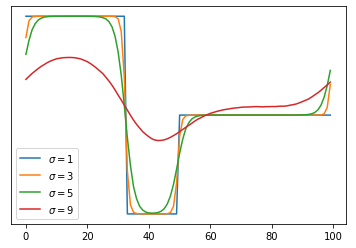

In [15]:
Means = np.array([np.roll(x, k) for k in range(N)])
Err=[]
#Sigma=np.linspace(1,15,30)

Sigma = [1,3,5,9]

cur_axes = plt.gca()
for sigma in Sigma :
  
    mu_barre = SGD( Means, N=1000, D = 100, K =100)
            
    signals = alignement(mu_barre)
    
    sig = np.mean(signals, axis = 0)
    new_mu = np.array([np.roll(sig, k) for k in range(100)])
    index_roll = np.argmin(np.linalg.norm(new_mu - x, axis =1))
    sig = np.roll(sig, index_roll)

    plt.plot(sig, label = r'$\sigma =$' + str(sigma))
    Err.append(np.linalg.norm(sig-x)/np.linalg.norm(x))

cur_axes.axes.get_yaxis().set_visible(False)
plt.legend()
plt.savefig('reconstruction.pdf')



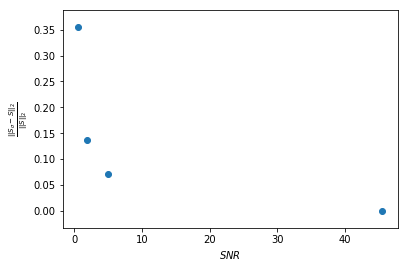

In [16]:
SNR = np.array([np.mean(x**2)/(sigma**2) for sigma in Sigma[:]  ])

plt.scatter(SNR , Err[:])
plt.xlabel(r'$SNR$')
plt.ylabel(r'$\frac{||S_\sigma-S||_2}{||S||_2}$')
#plt.title('Signal reconstruction with respect to sigma')
plt.savefig('error.pdf')
plt.show()